In [1]:
import numpy as np
import tensorflow as tf  # For tf.data
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras
import cv2
import os
import random
from keras import layers
from sklearn.model_selection import train_test_split
from keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

IMG_SIZE = 	224
BATCH_SIZE = 64
DATA_FOLDER = 'datos'

labels = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

# Función para cargar y preprocesar datos
def get_data(path, label):
    data = [] 
    for img in os.listdir(path + '/' + label):
        try:
            img_bgr = cv2.imread(os.path.join(path + '/' + label, img)) 
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # convert BGR to RGB format
            resized_arr = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))  # Reshaping images to preferred size
            data.append(resized_arr)
        except Exception as e:
            print(e)
    return data

# Separar datos en entrenamiento y validación
train_data, validation_data = [], []
for label in labels:
    data = get_data(DATA_FOLDER, label)
    train_data_splited, validation_data_splited = train_test_split(data, test_size=0.2)
    train_data.append(train_data_splited)
    validation_data.append(validation_data_splited)

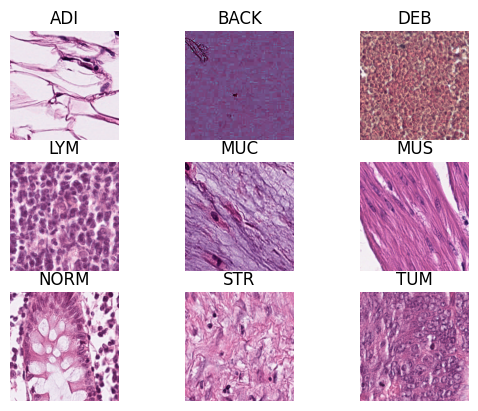

In [2]:
# Graficar ejemplos de datos
labels_sample = []
for i in range(len(train_data)):
    labels_sample.append((train_data[i][3], labels[i]))
for i, (image, label) in enumerate(labels_sample):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title("{}".format(label))
    plt.axis("off")

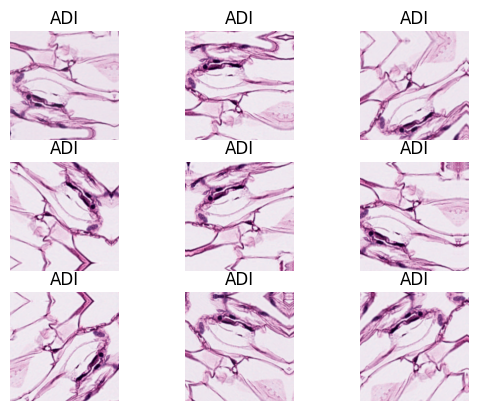

In [3]:
# Data augmentation

img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1)
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_img = img_augmentation(np.expand_dims(train_data[0][3], axis=0))
    plt.imshow(aug_img[0].numpy().astype("uint8"))
    plt.title("{}".format("ADI"))
    plt.axis("off")

In [4]:
augmented_train_data_x = [[img_augmentation(train_data[i][j]) for j in range(len(train_data[i]))] for i in range(len(labels))]
augmented_validation_data_x = [[img_augmentation(validation_data[i][j]) for j in range(len(validation_data[i]))] for i in range(len(labels))]

# Crear conjuntos de datos del mismo tamaño
max_data_size = max([len(data) for data in train_data])
for i in range(len(labels)):
    for _ in range(max_data_size - len(train_data[i])):
        aug_img = img_augmentation(train_data[i][random.randrange(0, len(train_data[i]))])
        augmented_train_data_x[i].append(aug_img)

max_data_size = max([len(data) for data in validation_data])
for i in range(len(labels)):
    for _ in range(max_data_size - len(validation_data[i])):
        aug_img = img_augmentation(validation_data[i][random.randrange(0, len(validation_data[i]))])
        augmented_validation_data_x[i].append(aug_img)

MODELO MULTICLASE

In [5]:
final_train_data_x = []
final_validation_data_x = []
for i in range(len(labels)):
    for j in range(len(augmented_train_data_x[i])):
        final_train_data_x.append(augmented_train_data_x[i][j])

for i in range(len(labels)):
    for j in range(len(augmented_validation_data_x[i])):
        final_validation_data_x.append(augmented_validation_data_x[i][j])

final_train_data_y = []
final_validation_data_y = []
for i in range(len(labels)):
    for j in range(len(augmented_train_data_x[i])):
        final_train_data_y.append(tf.one_hot(i, len(labels)))

for i in range(len(labels)):
    for j in range(len(augmented_validation_data_x[i])):
        final_validation_data_y.append(tf.one_hot(i, len(labels)))

final_train_data_y = np.array(final_train_data_y)
final_validation_data_y = np.array(final_validation_data_y)

final_train_data_x = [tf.convert_to_tensor(data) for data in final_train_data_x]
final_train_data_x = tf.data.Dataset.from_tensor_slices(final_train_data_x)
final_train_data_y = [tf.convert_to_tensor(data) for data in final_train_data_y]
final_train_data_y = tf.data.Dataset.from_tensor_slices(final_train_data_y)
train_dataset = tf.data.Dataset.zip((final_train_data_x, final_train_data_y))
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

final_validation_data_x = [tf.convert_to_tensor(data) for data in final_validation_data_x]
final_validation_data_x = tf.data.Dataset.from_tensor_slices(final_validation_data_x)
final_validation_data_y = [tf.convert_to_tensor(data) for data in final_validation_data_y]
final_validation_data_y = tf.data.Dataset.from_tensor_slices(final_validation_data_y)
validation_dataset = tf.data.Dataset.zip((final_validation_data_x, final_validation_data_y))
validation_dataset = validation_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)


In [21]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=len(labels),
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_3[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 225, 225, 3)          0         ['normalization_3

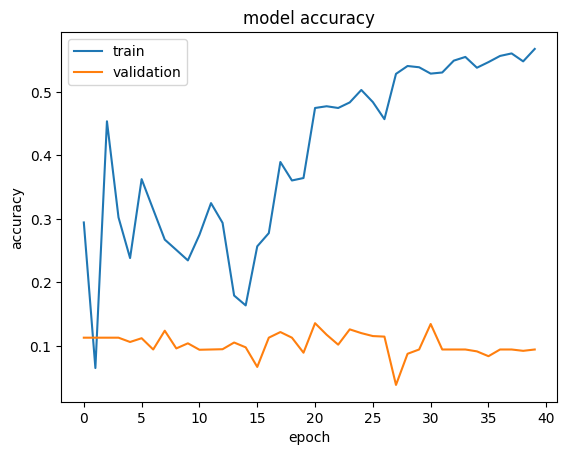

In [22]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

2/2 [==============================] - 0s 132ms/step
Accuracy: 0.0945945945945946


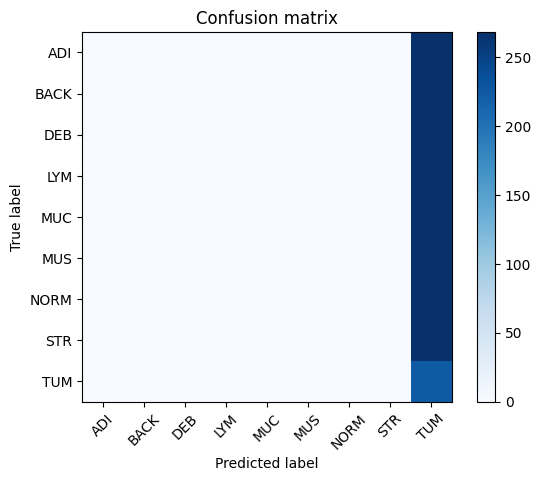

              precision    recall  f1-score   support

         ADI       0.00      0.00      0.00       268
        BACK       0.00      0.00      0.00       268
         DEB       0.00      0.00      0.00       268
         LYM       0.00      0.00      0.00       268
         MUC       0.00      0.00      0.00       268
         MUS       0.00      0.00      0.00       268
        NORM       0.00      0.00      0.00       268
         STR       0.00      0.00      0.00       268
         TUM       0.09      1.00      0.17       224

    accuracy                           0.09      2368
   macro avg       0.01      0.11      0.02      2368
weighted avg       0.01      0.09      0.02      2368



c:\Users\Usuario\git\Practica2IA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\git\Practica2IA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\git\Practica2IA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [23]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Función para imprimir el reporte de clasificación
def print_classification_report(y_true, y_pred, labels):
    print(classification_report(y_true, y_pred, target_names=labels))

# Convertir a un array numpy
y_true_multi = []
for item in validation_dataset:
    y_true_multi.extend(item[1].numpy())
y_true_multi = np.argmax(np.array(y_true_multi), axis=1)

# Predecir clases
predictions_multi = []
for item in validation_dataset:
    predictions_multi.extend(np.argmax(model.predict(item[0]), axis=1))
y_pred_multi = np.array(predictions_multi)

# Accuracy
accuracy_multi = np.mean(y_true_multi == y_pred_multi)
print("Accuracy:", accuracy_multi)

# Matriz de confusión
plot_confusion_matrix(y_true_multi, y_pred_multi, labels)

# Reporte de clasificación
print_classification_report(y_true_multi, y_pred_multi, labels)

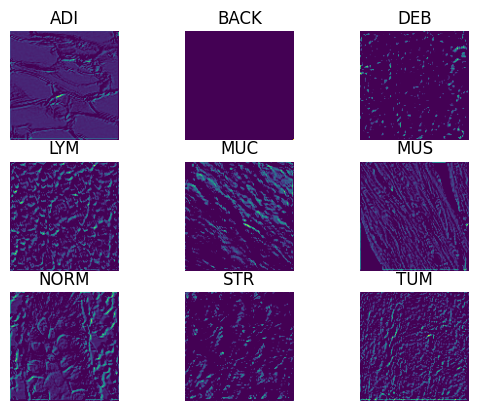

In [24]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

last_layer_name = "block1a_dwconv"
heatmap_sample = []
for i in range(len(train_data)):
    heatmap_sample.append(make_gradcam_heatmap(np.expand_dims(train_data[i][3], axis=0), model, last_layer_name))
for i, image in enumerate(heatmap_sample):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title("{}".format(labels[i]))
    plt.axis("off")

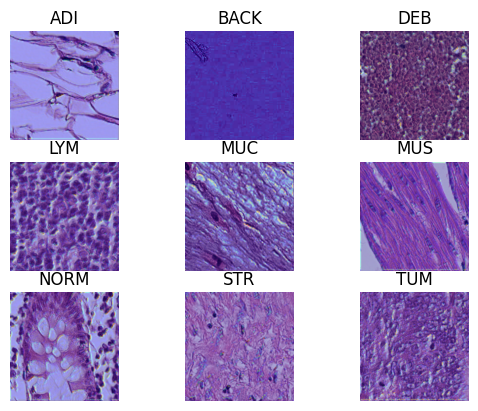

In [25]:
def display_gradcam(img, heatmap, alpha=0.5):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return superimposed_img

mixed_sample = []
for i in range(len(train_data)):
    mixed_sample.append(display_gradcam(train_data[i][3], heatmap_sample[i]))
for i, image in enumerate(mixed_sample):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title("{}".format(labels[i]))
    plt.axis("off")


MODELO BINARIO

In [26]:
bin_final_train_data_x = []
bin_final_validation_data_x = []
for i in range(len(labels)):
    for j in range(len(augmented_train_data_x[i])):
        bin_final_train_data_x.append(augmented_train_data_x[i][j])

for i in range(len(labels)):
    for j in range(len(augmented_validation_data_x[i])):
        bin_final_validation_data_x.append(augmented_validation_data_x[i][j])

bin_final_train_data_y = []
bin_final_validation_data_y = []
for i in range(len(labels)):
    for j in range(len(augmented_train_data_x[i])):
        bin_final_train_data_y.append(0 if labels[i] == 'TUM' else 1)

for i in range(len(labels)):
    for j in range(len(augmented_validation_data_x[i])):
        bin_final_validation_data_y.append(0 if labels[i] == 'TUM' else 1)

bin_final_train_data_y = np.array(bin_final_train_data_y)
bin_final_validation_data_y = np.array(bin_final_validation_data_y)

bin_final_train_data_x = [tf.convert_to_tensor(data) for data in bin_final_train_data_x]
bin_final_train_data_x = tf.data.Dataset.from_tensor_slices(bin_final_train_data_x)
bin_final_train_data_y = [tf.convert_to_tensor(data) for data in bin_final_train_data_y]
bin_final_train_data_y = tf.data.Dataset.from_tensor_slices(bin_final_train_data_y)
bin_train_dataset = tf.data.Dataset.zip((bin_final_train_data_x, bin_final_train_data_y))
bin_train_dataset = bin_train_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)
bin_train_dataset = bin_train_dataset.prefetch(tf.data.AUTOTUNE)

bin_final_validation_data_x = [tf.convert_to_tensor(data) for data in bin_final_validation_data_x]
bin_final_validation_data_x = tf.data.Dataset.from_tensor_slices(bin_final_validation_data_x)
bin_final_validation_data_y = [tf.convert_to_tensor(data) for data in bin_final_validation_data_y]
bin_final_validation_data_y = tf.data.Dataset.from_tensor_slices(bin_final_validation_data_y)
bin_validation_dataset = tf.data.Dataset.zip((bin_final_validation_data_x, bin_final_validation_data_y))
bin_validation_dataset = bin_validation_dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [27]:
base_model = EfficientNetB0(
    include_top=False,  # Cambiar a False
    weights=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

# Añadir una nueva capa de clasificación binaria
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

# Crear el nuevo modelo
binary_model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

binary_model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
bin_hist = binary_model.fit(bin_train_dataset, epochs=epochs, validation_data=bin_validation_dataset)

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 normalization_4 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 225, 225, 3)          0         ['normalization_4[0][0]

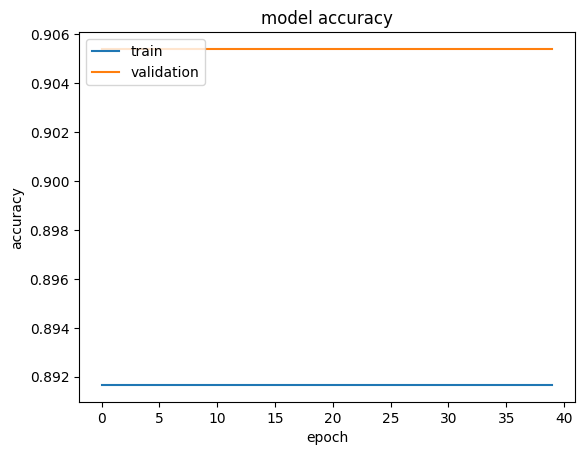

In [28]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(bin_hist)

2/2 [==============================] - 0s 137ms/step
Accuracy: 0.9054054054054054


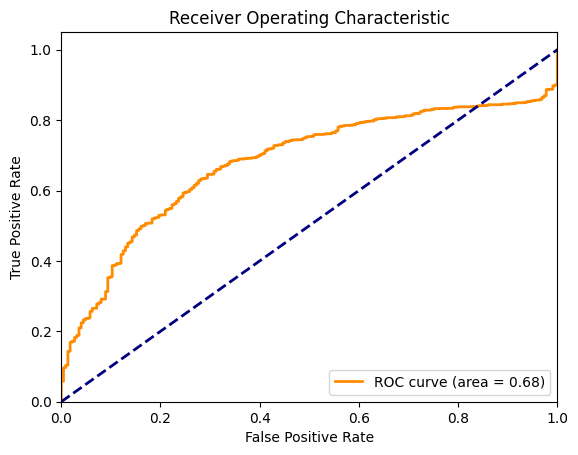

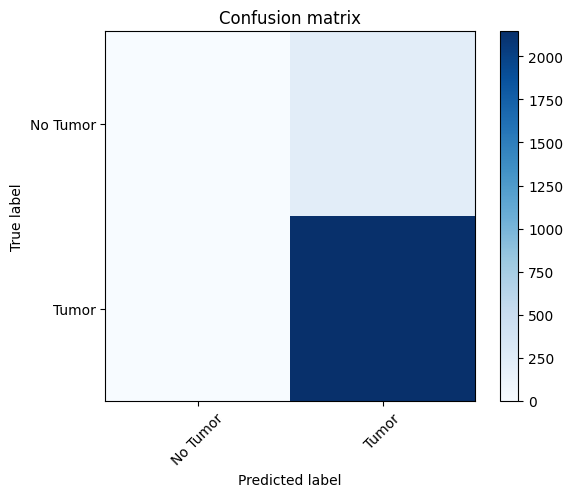

              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00       224
       Tumor       0.91      1.00      0.95      2144

    accuracy                           0.91      2368
   macro avg       0.45      0.50      0.48      2368
weighted avg       0.82      0.91      0.86      2368



c:\Users\Usuario\git\Practica2IA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\git\Practica2IA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\git\Practica2IA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [29]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Función para graficar la curva ROC
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Convertir el conjunto de datos a una lista y luego a un array numpy
y_true_bin = []
for item in bin_validation_dataset:
    y_true_bin.extend(item[1].numpy())
y_true_bin = np.array(y_true_bin)

# Predecir clases
predictions_bin = []
for item in bin_validation_dataset:
    predictions_bin.extend(binary_model.predict(item[0]))
predictions_bin = np.array(predictions_bin)

# Convertir las predicciones a clases binarias
y_pred_bin = (predictions_bin > 0.5).astype(int)

# Accuracy
accuracy_bin = np.mean(y_true_bin == y_pred_bin)
print("Accuracy:", accuracy_bin)

# Curva ROC
plot_roc_curve(y_true_bin, predictions_bin)

# Matriz de confusión
plot_confusion_matrix(y_true_bin, y_pred_bin, ['No Tumor', 'Tumor'])

# Reporte de clasificación
print_classification_report(y_true_bin, y_pred_bin, ['No Tumor', 'Tumor'])
